# Segmenting Customers with Python

## Import Data
Import our needed libraries and the Excel sheet to the dataframe **df**.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel('sales_details.xlsx', sheet_name = 'Sheet1')
df.columns = ['Invoice','Product','Title','Quantity','Date','Price','CustomerKey','Name','State','Vendor']
df.head()

,Invoice Number,Product Key,Title,Qty Ordered,Invoice Date,Net Price,Customer Key,Customer Name,State,Vendor Key
0,891506,1404256598,PLAY BALL,6,2020-07-01,3.09,006344,THE FOREIGN BUYERS' CLUB,CA,ROSNP
1,891506,9781480745230,WHAT DO LIVING THINGS NEED,6,2020-07-01,5.99,006344,THE FOREIGN BUYERS' CLUB,CA,SHELE
2,891506,9781598451603,ALL ABOUT BABY ANIMALS BABY SNOW ANIMALS,6,2020-07-01,5.61,006344,THE FOREIGN BUYERS' CLUB,CA,ENSLO
3,891506,9781598451610,ALL ABOUT BABY ANIMALS BABY FOREST ANIMALS,6,2020-07-01,5.61,006344,THE FOREIGN BUYERS' CLUB,CA,ENSLO
4,891506,9781877506079,OUT IN SPACE,6,2020-07-01,4.20,006344,THE FOREIGN BUYERS' CLUB,CA,FLYSB


## Data Cleanup
This is a very important step! We need to perform the following functions:
1. Remove cancelled orders (anything with a quantity of 0 or less)
2. Remove records with missing CustomerID
3. The dataset ends in a partial month so we need to exclude that month so that we are only handling complete months.

**Filtering to any quantities greater than 0**

In [4]:
df = df.loc[df['Quantity'] > 0]

**Removing missing Customer Key rows**

In [5]:
df = df[pd.notnull(df['CustomerKey'])]

**Excluding ending month which is a partial month**

In [6]:
#df = df.loc[df['InvoiceDate'] < '2011-12-01']

## Feature Engineering
We want to create some additional features that will be useful in our customer segmentation analysis.
1. Compute total sales
2. Aggregate and summarize our data by customer
3. Normalize our data for easier machine learning

**Computing total sales**

In [7]:
df['Sales'] = df['Quantity'] * df['Price']

**Aggregate and summarize by customer**

We want to determine the total sales amount, number of orders, and average order amounts.

In [8]:
customer_df = df.groupby('CustomerKey').agg({
    'Sales': sum,
    'Invoice': lambda x: x.nunique()
})
customer_df.columns = ['TotalSales','OrderCount']
customer_df.head()

,TotalSales,OrderCount
CustomerKey,,
000155,14104.74,7
000170,10730.16,4
000179,365.52,1
000182,2753.28,2
000238,9872.44,4


In [9]:
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']
customer_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerKey,,,
000155,14104.74,7,2014.962857
000170,10730.16,4,2682.540000
000179,365.52,1,365.520000
000182,2753.28,2,1376.640000
000238,9872.44,4,2468.110000
000244,4490.97,5,898.194000
000274,13161.83,5,2632.366000
000306,488.28,3,162.760000
000332,8594.14,8,1074.267500


Clustering algorithms are affected by the scale of the data so now we move to normalize the data. We do this in two parts. First, the data is transformed into its rank. Then, we normalize the ranked data. Through normalizing the data, the data is centered on the mean and the mean is **0** with a standard deviation of **1**.

In [10]:
rank_df = customer_df.rank(method = 'first')
rank_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerKey,,,
000155,1312.0,1256.0,1183.0
000170,1259.0,1101.0,1263.0
000179,434.0,1.0,563.0
000182,970.0,683.0,1068.0
000238,1252.0,1102.0,1239.0
000244,1079.0,1181.0,910.0
000274,1303.0,1182.0,1256.0
000306,501.0,972.0,281.0
000332,1224.0,1274.0,989.0


In [11]:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerKey,,,
000155,1.389925,1.256644,1.082904
000170,1.263784,0.887743,1.273304
000179,-0.699722,-1.730266,-0.392701
000182,0.575962,-0.107100,0.809203
000238,1.247124,0.890123,1.216184
000244,0.835383,1.078144,0.433161
000274,1.368505,1.080524,1.256644
000306,-0.540262,0.580722,-1.063864
000332,1.180484,1.299484,0.621182


## K-Means Clustering
The **k-means clustering** algorithm is a very frequently used algorithm for segmenting customers and understanding their behaviors. Running the algorithm only takes two lines of code: **(1)** importing the KMeans module from scikit-learn and **(2)** writing the one line of code to build the model.

In [12]:
from sklearn.cluster import KMeans

In [13]:
kmeans = KMeans(n_clusters = 4).fit(normalized_df[['TotalSales','OrderCount','AvgOrderValue']])

The above line of code splits the data into four segments based on the total sales, order counts, and average order value. Each cluster is given a label and a centered value which can be obtained below.

In [14]:
kmeans.labels_

array([2, 2, 3, ..., 2, 3, 0])

In [15]:
kmeans.cluster_centers_

array([[ 0.10317335,  0.7168287 , -0.28252184],
       [ 0.22644712, -0.84390825,  0.80614783],
       [ 1.22313628,  1.01034476,  1.01016313],
       [-1.14680716, -0.7949667 , -1.04620661]])

**Visualize the clustered data**

We begin by making a copy of the normalized dataframe and by adding in the cluster label for each CustomerID.

In [16]:
four_cluster_df = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerKey,,,,
000155,1.389925,1.256644,1.082904,2
000170,1.263784,0.887743,1.273304,2
000179,-0.699722,-1.730266,-0.392701,3
000182,0.575962,-0.107100,0.809203,1
000238,1.247124,0.890123,1.216184,2
000244,0.835383,1.078144,0.433161,2
000274,1.368505,1.080524,1.256644,2
000306,-0.540262,0.580722,-1.063864,0
000332,1.180484,1.299484,0.621182,2


Now that each CustomerID has its cluster value (1-4), we can plot it. Given the three different columns (total sales, order count, and average order value), we can create a few different plots to compare these various columns. Each cluster will be given a different color.

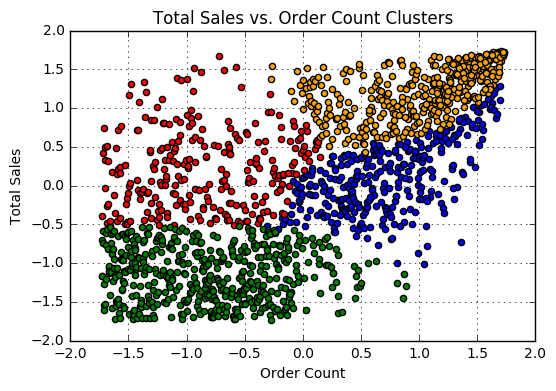

In [17]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c = 'green')

plt.title('Total Sales vs. Order Count Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

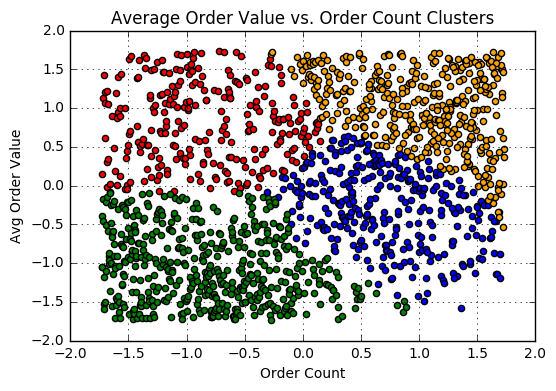

In [18]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c = 'green')

plt.title('Average Order Value vs. Order Count Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

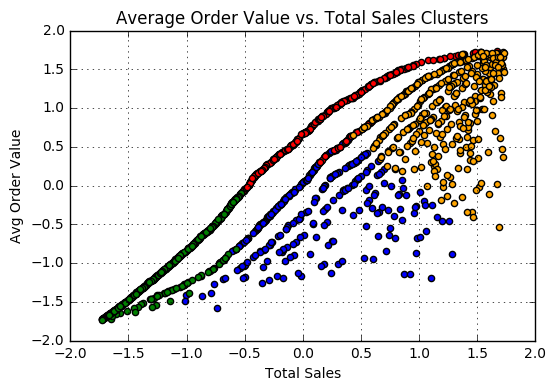

In [19]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c = 'green')

plt.title('Average Order Value vs. Total Sales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

## Determining the Best Number of Clusters
We normally do not know how many clusters to choose. In this case, we began by selecting four clusters. We can use a method of scoring called the **silhouette coefficient** to determine how many clusters to choose. We will run the KMeans algorithm through a loop of cluster values and record the silhouette scores for each cluster. After running the loop, we will print the results and look for the cluster value with the highest score (ranging from 0-1).

In [20]:
from sklearn.metrics import silhouette_score

In [23]:
for n_cluster in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters = n_cluster).fit(
        normalized_df[['TotalSales','OrderCount','AvgOrderValue']]
    )
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales','OrderCount','AvgOrderValue']],
        kmeans.labels_
    )
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 4 Clusters: 0.4232
Silhouette Score for 5 Clusters: 0.3822
Silhouette Score for 6 Clusters: 0.3626
Silhouette Score for 7 Clusters: 0.3764
Silhouette Score for 8 Clusters: 0.3635


In this case, we did have the best number of clusters chosen since four clusters had the highest silhouette score of 0.4117.

## Insights from Customer Segments
Now that customers are segmented, what is next? We can analyze the results to determine customer trends and can identify frequently purchased items amongst customers in each segment.

First, we do need to redo our k-means clustering model using four clusters (the loop in the previous section left off with eight clusters so we want to make sure we are using the best model).

In [24]:
kmeans = KMeans(n_clusters = 4).fit(
    normalized_df[['TotalSales','OrderCount','AvgOrderValue']]
    )
four_cluster_df = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
four_cluster_df['Cluster'] = kmeans.labels_

We can look at the cluster centers for each cluster and attribute. We can use the cluster_centers_ code to list out these values in an array but we will go one step further and place these into an easy to read dataframe.

In [25]:
kmeans.cluster_centers_

array([[ 0.10317335,  0.7168287 , -0.28252184],
       [-1.14680716, -0.7949667 , -1.04620661],
       [ 0.22644712, -0.84390825,  0.80614783],
       [ 1.22313628,  1.01034476,  1.01016313]])

In [26]:
clusters_df = pd.DataFrame(data = kmeans.cluster_centers_,
                           index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'],
                           columns = ['TotalSales','OrderCount','AvgOrderValue']
                          )
clusters_df

,TotalSales,OrderCount,AvgOrderValue
Cluster 0,0.103173,0.716829,-0.282522
Cluster 1,-1.146807,-0.794967,-1.046207
Cluster 2,0.226447,-0.843908,0.806148
Cluster 3,1.223136,1.010345,1.010163


The above table gives us the normalized values of the cluster centers. We see that cluster 2 has the highest values for all three attributes - these are the high-value customers who bring in a lot of business. Cluster 1 are low-value customers because they have the lowest values in total sales and average order value. Cluster 3 does have a lower value in order count but it is very close to cluster 1. Cluster 3 has a high average order value though so we can infer that cluster 3 customers have infrequent purchases but they have a great average value though.

We can also assign the cluster values to the original **customer_df** in order to see the actual values instead of the normalized values.

In [32]:
actuals_df = customer_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
actuals_df['Cluster'] = kmeans.labels_
actuals_df.head(20)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerKey,,,,
000155,14104.74,7,2014.962857,3
000170,10730.16,4,2682.540000,3
000179,365.52,1,365.520000,1
000182,2753.28,2,1376.640000,2
000238,9872.44,4,2468.110000,3
000244,4490.97,5,898.194000,3
000274,13161.83,5,2632.366000,3
000306,488.28,3,162.760000,0
000332,8594.14,8,1074.267500,3


We can also look at the best selling items for each customer segment. Let's look at cluster 2, our high-value customers.

In [28]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 3]

In [31]:
pd.DataFrame(
    df.loc[
        df['CustomerKey'].isin(high_value_cluster.index)
    ].groupby('Title').count()[
        'Product'
    ].sort_values(ascending = False).head(20)
)

,Product
Title,
THREE LITTLE PIGS,475
THREE BILLY GOATS GRUFF,460
SHARKS,452
BIG DOG AND LITTLE DOG GREEN LIGHT READER LEVEL 1,436
KING AND KAYLA AND THE CASE OF THE MISSING DOG TREATS,436
SUBWAY RIDE,414
PUG,406
PEDRO'S MYSTERY CLUB,399
PEDRO FOR PRESIDENT,387
